Importing gempy



In [1]:
# Aux imports
import gempy as gp
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import gstools as gs
import pyvista as pv
import pyvistaqt as pvqt
import PVGeo
import glob
import random
from tqdm import tqdm
from numpy import cross, eye, dot
from scipy.linalg import expm, norm
from sklearn import preprocessing
from pyvista import set_plot_theme
np.random.seed(1515)
pd.set_option('precision', 2)
%matplotlib inline
set_plot_theme('document')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\pasha\python\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


No module named 'osgeo'


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We import a model from an existing folder, representing a subduction
zone with onlap relationships. The theano function is automatically
recombined to allow changes.




In [16]:
#define resolution and mesh size
reso=[50, 50, 50]
mesh_size = reso[0]*reso[1]*reso[2]
extent=[0, 1494, 0, 1000, -1119, 0]
print(' mesh size: ' + str(mesh_size))

 mesh size: 125000


In [17]:
geo_data = gp.create_data('foresets', extent=extent, resolution=reso,
                          path_o="2_orientation_data.csv",
                          path_i="1_point_data_all.csv")

gp.map_stack_to_surfaces(geo_data, {"Strat_Series1": ('Premine topo'),
                                    "Strat_Series2":('Quartz monzonite porphyry'),
                                    "Strat_Series3":('Equigranular Monzonite'),
                                    "Host_Rock": ('basement')})

Active grids: ['regular']


,surface,series,order_surfaces,color,id
1,Premine topo,Strat_Series1,1,#9f0052,1
2,Quartz monzonite porphyry,Strat_Series2,1,#ffbe00,2
0,Equigranular Monzonite,Strat_Series3,1,#015482,3
3,basement,Host_Rock,1,#728f02,4


In [18]:
geo_data.series

,order_series,BottomRelation,isActive,isFault,isFinite
Strat_Series1,1,Erosion,True,False,False
Strat_Series2,2,Erosion,True,False,False
Strat_Series3,3,Erosion,True,False,False
Host_Rock,4,Erosion,False,False,False


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


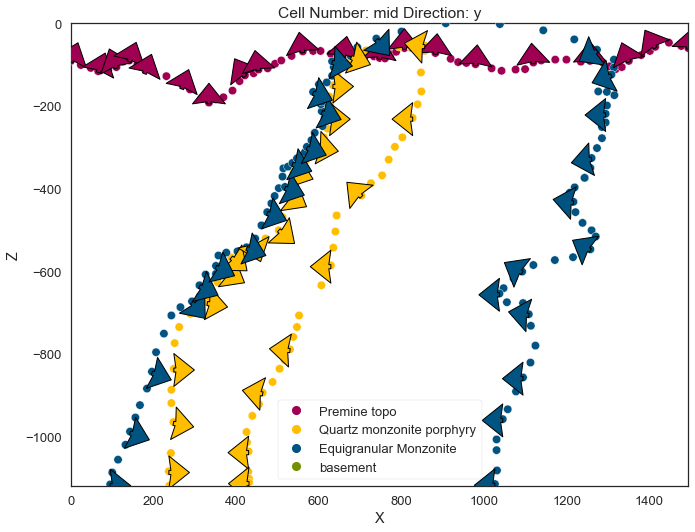

In [19]:
gp.plot_2d(geo_data, figsize=(10,10))

In [20]:
geo_data.set_topography()

[-223.8    0. ]
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   14.94      ,    10.        , -1107.81      ],
       [   14.94      ,    10.        , -1085.43      ],
       [   14.94      ,    10.        , -1063.05      ],
       ...,
       [ 1494.        ,   959.18367347,   -60.59820861],
       [ 1494.        ,   979.59183673,   -69.25775149],
       [ 1494.        ,  1000.        ,   -67.40721752]])

In [21]:
interp_data = gp.set_interpolator(geo_data, compile_theano=True,theano_optimizer='fast_compile')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                        values
range                 2117.59
$C_o$                106766.6
drift equations  [3, 3, 3, 3]


In [22]:
%%time
sol = gp.compute_model(geo_data, compute_mesh=True, debug=False)

Wall time: 19.3 s


C:\Users\pasha\python\lib\site-packages\gempy\core\solution.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.geological_map = np.array(


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


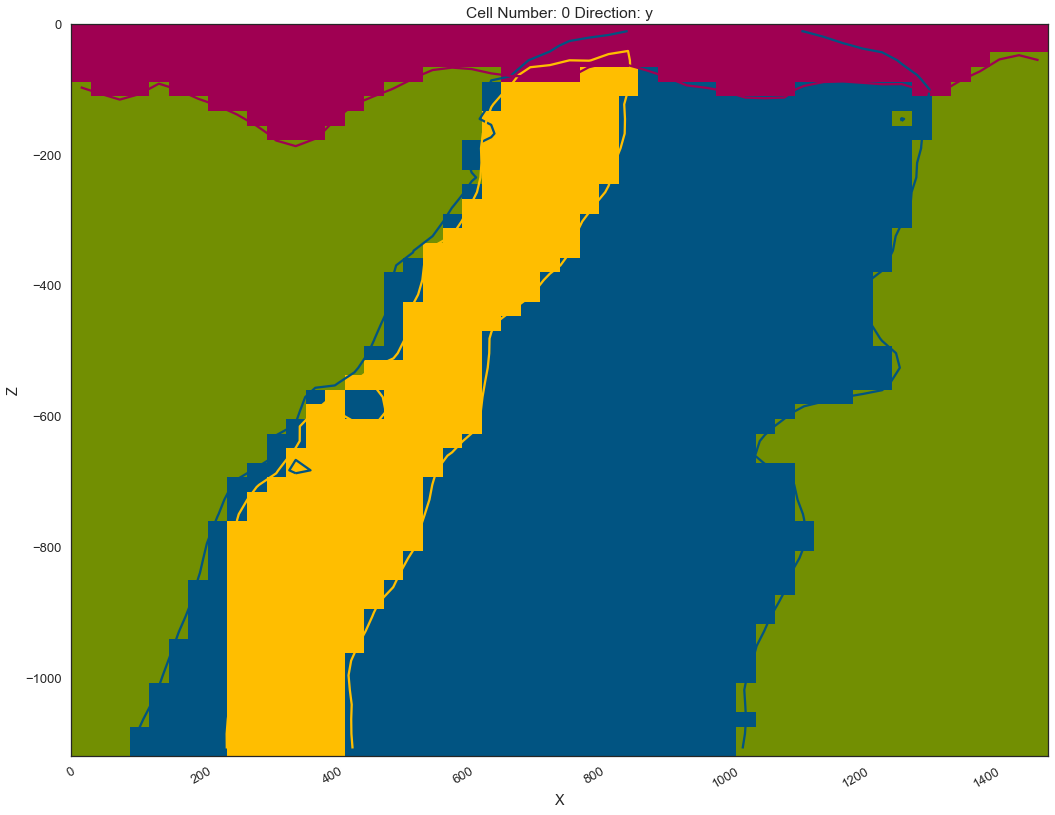

In [23]:
gp.plot_2d(geo_data, cell_number=0, show_data=False, figsize=(15,15))

In [65]:
p3d = gp.plot_3d(geo_data, plotter_type='background', show_lith=True, show_surfaces=True,  show_data=True, image=False,
                 show_topography=True,
                 kwargs_plot_structured_grid={'opacity': .5})

gp.save_model(geo_data)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


True

In [24]:
### User-defined functions
def extract_domain(sol, unit):
    '''
    Extract domain coordinates from gempy model by unit name
    arguments:
        sol: Gempy solution object.
        unit: gempy unit by index
    returns:
        dom_x, dom_y, dom_z: coordinates of domain
    '''

    # new version with rounding, definitely necessary
    rounded_lithblock = sol.lith_block.round(0)
    rounded_lithblock = rounded_lithblock.astype(int)

    # mask by array of input surfaces (by id, can be from different series)
    mask = np.isin(rounded_lithblock, unit)

    # get coordinates by mask, mesh_size is defined on in[55]
    #krig_lith = sol.lith_block[mask]
    dom_grid = sol.grid.values[:mesh_size][mask]

    dom_x = dom_grid[:,0]
    
    dom_y = dom_grid[:,1]
    dom_z = dom_grid[:,2]

    return dom_x, dom_y, dom_z

In [25]:
unit_count=int(np.max(sol.lith_block.round(0)))
series_count=len(sol.scalar_field_matrix)
unit_count, series_count

(4, 3)

### Geostatistics and Kriging

In [19]:
df =pd.read_csv('3_kriging_Au.csv')
df

,X,Y,Z,grade_value,grade
0,440,0,-211,0.81,grade1boundary
1,460,0,-142,0.81,grade1boundary
2,497,0,-80,0.82,grade1boundary
3,562,0,-39,0.82,grade1boundary
4,649,0,-10,0.83,grade1boundary
...,...,...,...,...,...
179,1003,0,-231,0.49,grade3inside
180,1008,0,-192,0.49,grade3inside
181,975,0,-159,0.49,grade3inside
182,985,0,-116,0.49,grade3inside


In [20]:
# load grade input data (conditioning data)
n=len(df.iloc[:,1])
x = df.iloc[:n,0]
y = df.iloc[:n,1]
z = df.iloc[:n,2]
cond_pos = np.array([x,y,z])
cond_val = df.iloc[:n,3]

In [24]:
# This is to extract smaller domains from gempy by 

domain_x, domain_y, domain_z = extract_domain(sol, (2,3,4))

In [25]:
# grid coordinate preparation
coordinates = np.array([domain_x, domain_y, domain_z])
coordinates = coordinates.swapaxes(0,1)
    
# This is where the magic happens - GStools offers a lot of options, here a simple version with isotropic range
#(CondSRF - conditional spatial random fields)
model = gs.Exponential(dim=3, var=np.var(cond_val), len_scale=200)
krige = gs.krige.Ordinary(model, cond_pos, cond_val)
cond_srf = gs.CondSRF(krige)

# perform kriging
krige((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')
# alternatively fior SGS
#cond_srf((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')

# just convenience rename
field = krige
# alternatively for SGS
#field = cond_srf

In [26]:
# convert to pyvista mesh
pc = field.to_pyvista()

In [27]:
# 3D plotting example
spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

pc = pc.cast_to_unstructured_grid()

grade = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], estimate=False).apply(pc)

In [28]:
#p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap=cmap)
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=False,
                kwargs_plot_structured_grid={'opacity': .5})
gpv.p.add_mesh(grade, opacity=1, show_edges=False, lighting=False, cmap="terrain")

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000002310BF1DDC0

### Calculating Cu ore volume

In [107]:
#define grade intervals and check the count of voxels corresponding to the same interval
ore_interval1=[]
ore_interval2=[]
ore_interval3=[]
ore_dict={}
for index in tqdm(range(0, len(grade.active_scalars))):
    #for Cu Horizon I:
    if grade.active_scalars[index]>0.7:
        ore_interval1.append(grade.active_scalars[index])
        ore_dict.update({1: ore_interval1})
    #for Cu Horizon II:
    elif 0.7>grade.active_scalars[index]>0.6:        
        ore_interval2.append(grade.active_scalars[index])
        ore_dict.update({2: ore_interval2})
        
    #for Cu Horizon III:
    elif 0.5>grade.active_scalars[index]>0.43:        
        ore_interval3.append(grade.active_scalars[index])
        ore_dict.update({3: ore_interval3})
        
#calculate volume of total voxels corresponding to a certain ore grade interval
voxel_volume=((extent[1]-extent[0])/reso[0])*((extent[3]-extent[2])/reso[1])*((extent[5]-extent[4])/reso[2])

for i in range(1,4):
    ore_avrg_grade=np.mean(ore_dict[i])
    volume=len(ore_dict[i])*(voxel_volume)
    print("Horizon{} = ".format(i),volume)
    print("Average ore grade=", ore_avrg_grade)

100%|████████████████████████████████| 902271/902271 [11:56<00:00, 1259.51it/s]

Horizon1 =  15846859.494
Average ore grade= 0.7623248257039079
Horizon2 =  30670585.956
Average ore grade= 0.6435096084912928
Horizon3 =  1293582868.578
Average ore grade= 0.4771961746309947


### Calculating Au ore volume

In [20]:
#define grade intervals and check the count of voxels corresponding to the same interval
ore_interval1=[]
ore_interval2=[]
ore_interval3=[]
ore_dict={}
for index in tqdm(range(0, len(grade.active_scalars))):
    #for Cu Horizon I:
    if 0.3>grade.active_scalars[index]>0.1:
        ore_interval1.append(grade.active_scalars[index])
        ore_dict.update({1: ore_interval1})
    #for Cu Horizon II:
    elif 0.6>grade.active_scalars[index]>0.3:        
        ore_interval2.append(grade.active_scalars[index])
        ore_dict.update({2: ore_interval2})
        
    #for Cu Horizon III:
    elif 1.1>grade.active_scalars[index]>0.6:        
        ore_interval3.append(grade.active_scalars[index])
        ore_dict.update({3: ore_interval3})
        
#calculate volume of total voxels corresponding to a certain ore grade interval
voxel_volume=((extent[1]-extent[0])/reso[0])*((extent[3]-extent[2])/reso[1])*((extent[5]-extent[4])/reso[2])

for i in range(1,4):
    ore_avrg_grade=np.mean(ore_dict[i])
    volume=len(ore_dict[i])*(voxel_volume)
    print("Horizon{} = ".format(i),volume)
    print("Average ore grade=", ore_avrg_grade)

100%|████████████████████████████████| 219293/219293 [01:38<00:00, 2229.16it/s]

Horizon1 =  359673055.398
Average ore grade= 0.14689015292139987
Horizon2 =  5548657.734
Average ore grade= 0.3882861995741934
Horizon3 =  1028148.39
Average ore grade= 0.7625136395051352


### Extract kriged data

In [75]:
#extract voxel locations and ore grade value
main_array=pc.points.tolist()
added_array=grade.active_scalars.tolist()
n=len(main_array)

for index in range(0,n,1):
    main_array[index].append(added_array[index])
grade=pd.DataFrame(main_array, columns=['X','Y','Z','grade'])

In [76]:
#drill boreholess!!
def krige_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(grade)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in grade.itertuples():
            if (grade.iloc[rand_ind[index]].X==row.X and grade.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.grade])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','grade']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict

In [77]:
#create desired amount of random boreholes
boreholes=krige_boreholes(100)

100%|████████████████████████████████████████| 100/100 [13:48<00:00,  8.29s/it]


In [78]:
#join all borehole data into one dataframe
drill_all = pd.concat(boreholes.values(), ignore_index=True)

#define vertices for the mesh grid (showing boreholes)
vertices = drill_all[['X','Y','Z']].values
kriged=pv.PolyData(vertices)
kriged['grade'] = drill_all['grade'].values

In [81]:
list_tempo=[]
for index in range(0,len(drill_all),10):
    list_tempo.append(drill_all.iloc[index])
br=pd.DataFrame(list_tempo)

br.to_csv('3_kriging_Cu_100.csv')
br

,X,Y,Z,grade,borehole
0,1240.02,370.0,-1107.81,0.47,1.0
10,1240.02,370.0,-884.01,0.47,1.0
20,1240.02,370.0,-660.21,0.47,1.0
30,1240.02,370.0,-436.41,0.47,1.0
40,1240.02,370.0,-212.61,0.47,1.0
...,...,...,...,...,...
4360,1180.26,810.0,-167.85,0.48,99.0
4370,1449.18,950.0,-906.39,0.48,100.0
4380,1449.18,950.0,-682.59,0.48,100.0
4390,1449.18,950.0,-458.79,0.48,100.0


In [114]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(kriged, scalars='grade', opacity=1, cmap='viridis', point_size=5)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001E858AD5F40

### Extract orientation data from the solution

In [27]:
from numpy import cross, eye, dot
from scipy.linalg import expm, norm
from sklearn import preprocessing

#calculate gradient for orientation data
def get_gradient(sol, res, dim):
    '''
    Calculate gradient from model solution
    '''
    # scalar field as meshgrid
    dict_all={}
    dict_spec={}
    for index in range(0,series_count,1):
        scalar_mgrid = sol.scalar_field_matrix[index].reshape(res)

        # calculate gradient
        gx, gy, gz = np.gradient(scalar_mgrid)

       
        vectors = np.array([gx.reshape(int(res[0] ** dim)), gy.reshape(int(res[0] ** dim)), gz.reshape(int(res[0] ** dim))])
        vectors = np.swapaxes(vectors, 0, 1)
        vectors = preprocessing.normalize(vectors, norm='l2')
        dict_all.update({index:vectors})
         
    
    for index in range(0,series_count,1):
            data_temp = pd.DataFrame(dict_all[index])
            dict_spec.update({'series_{}'.format(index):data_temp})
    return dict_spec

dict_spec=get_gradient(sol, res=[50,50,50], dim=3)

# get cell coordinates and domain information
x = sol.grid.regular_grid.values[:, 0]
y = sol.grid.regular_grid.values[:, 1]
z = sol.grid.regular_grid.values[:, 2]
formation=sol.lith_block

#add cell coordinates and domain information to the orientations dictionary
for key,value in dict_spec.items():
    #load coordinate and formation array to the whole series dataframes
    value["X"]=x
    value['Y']=y
    value['Z']=z
    value['formation']=formation 
    #value = value.reset_index()
    #define column names
    value.columns=['G_x','G_y','G_z','X','Y','Z','formation']  

#define orientations for each domain    
dict_spec['series_0']=dict_spec['series_0'][dict_spec['series_0'].formation==1]
dict_spec['series_1']=dict_spec['series_1'][dict_spec['series_1'].formation==2]
dict_spec['series_2']=dict_spec['series_2'][dict_spec['series_2'].formation==3]

#join all orientation data
orientations = pd.concat([dict_spec['series_0'],dict_spec['series_1'],dict_spec['series_2']],ignore_index=True)

In [13]:
#extract mesh grid for ideal case 3D model
unit=range(0,unit_count+1)
for index in unit:
    domain_x, domain_y, domain_z = extract_domain(sol, (unit[index+1]))
    coordinates = np.array([domain_x, domain_y, domain_z])
    coordinates = coordinates.swapaxes(0,1)
    data=pd.DataFrame(coordinates, columns=['X','Y','Z'])
    data.loc[:, 'formation'] =float(unit[index+1])
    data.to_csv(r'data_extracted/ideal/unit_{}.csv'.format(unit[index+1]), mode="w", index=False)

IndexError: range object index out of range

In [29]:
# join all the files into one dataframe
path =r'data_extracted/ideal/'

filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all domain data into one DataFrame for ideal case mesh grid
ideal = pd.concat(dfs, ignore_index=True)
#df.drop(df.columns[[0]], axis=1, inplace=True)

#compare orientation data to ideal case data. Pick only the same cells in order to avoid basement data interference because
#basement data is not needed for model construction
df_same = orientations.merge(ideal, left_on=('X','Y','Z','formation'), right_on=('X','Y','Z','formation'), how='inner')
df_same = df_same[df_same.formation != unit_count]
df_same

,G_x,G_y,G_z,X,Y,Z,formation
0,0.38,-0.03,0.92,14.94,10.0,-78.33,1.0
1,0.33,-0.03,0.94,14.94,10.0,-55.95,1.0
2,0.26,-0.03,0.96,14.94,10.0,-33.57,1.0
3,0.22,-0.02,0.98,14.94,10.0,-11.19,1.0
4,0.37,-0.04,0.93,14.94,30.0,-78.33,1.0
...,...,...,...,...,...,...,...
35119,-0.98,-0.19,0.10,1269.90,110.0,-234.99,3.0
35120,-0.98,-0.20,0.03,1269.90,110.0,-212.61,3.0
35121,-0.97,-0.22,-0.09,1269.90,110.0,-167.85,3.0
35122,-0.95,-0.27,-0.16,1269.90,110.0,-145.47,3.0


In [79]:
#drill boreholess!!
def d_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(df_same)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in df_same.itertuples():
            if (df_same.iloc[rand_ind[index]].X==row.X and df_same.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.G_x, row.G_y, row.G_z, row.formation])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','G_x','G_y','G_z','formation']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict

#define desired number of boreholes
boreholes_dict=d_boreholes(100)

#join all borehole data into one dataframe
df = pd.concat(boreholes_dict.values(), ignore_index=True)
# boreholes_dict.to_csv('test100')

#load joined csv dataset
bore_count = df['borehole'].nunique()

#create mesh grid and define vertices, convert it to a pyvista poly data
vertices = df[['X', 'Y', 'Z']].values
grid=pv.PolyData(vertices)
grid['formation'] = df['formation'].values

  2%|▊                                         | 2/100 [00:07<05:47,  3.54s/it]


KeyboardInterrupt: 

In [234]:
unit=('Premine topo','Quartz monzonite porphyry','Equigranular Monzonite')
for index in range(1,unit_count):
    df['formation'] = df.loc[:,'formation'].replace(index,unit[index-1])
#df[df['formation']=='Quartz monzonite porphyry'] #- just for checking the dataset
df

,X,Y,Z,G_x,G_y,G_z,formation,borehole
0,552.78,550.0,-100.71,7.57e-03,5.45e-03,1.00,Premine topo,1
1,552.78,550.0,-78.33,6.11e-03,7.38e-03,1.00,Premine topo,1
2,552.78,550.0,-55.95,5.45e-03,9.01e-03,1.00,Premine topo,1
3,552.78,550.0,-33.57,5.53e-03,1.03e-02,1.00,Premine topo,1
4,552.78,550.0,-11.19,6.33e-03,1.14e-02,1.00,Premine topo,1
...,...,...,...,...,...,...,...,...
3127,493.02,110.0,-861.63,7.59e-01,-2.70e-02,-0.65,Equigranular Monzonite,99
3128,493.02,110.0,-839.25,8.02e-01,-2.89e-03,-0.60,Equigranular Monzonite,99
3129,493.02,110.0,-816.87,8.45e-01,1.75e-02,-0.53,Equigranular Monzonite,99
3130,493.02,110.0,-414.03,9.42e-01,3.88e-02,-0.33,Equigranular Monzonite,99


In [76]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(grid, scalars='formation', opacity=1, cmap='Paired', point_size=10)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000028D4BCE2DC0

Reduce extracted data points

In [235]:
#picking lowermost boundary for each formation through the borehole data 

dict_all=[]
list_temp=[]

for br in range(1,bore_count+1,1):
    for fr in range(1,form_count+1,1):
          list_temp.append(df[(df['borehole']==br) & (df['formation']==unit[fr-2])])
list_temp2=[]
for i in list_temp:
    if(not i.empty):
        list_temp2.append(i.iloc[0])
df_b=pd.DataFrame(list_temp2, index=range(0,len(list_temp2),1))
del df_b['borehole']
df_b

,X,Y,Z,G_x,G_y,G_z,formation
0,552.78,550.0,-1107.81,2.71e-01,-9.39e-01,-0.21,Equigranular Monzonite
1,552.78,550.0,-100.71,7.57e-03,5.45e-03,1.00,Premine topo
2,552.78,990.0,-78.33,1.38e-01,-1.26e-02,0.99,Premine topo
3,552.78,490.0,-1107.81,2.69e-01,-9.35e-01,-0.23,Equigranular Monzonite
4,552.78,490.0,-100.71,-2.53e-02,1.23e-02,1.00,Premine topo
...,...,...,...,...,...,...,...
189,493.02,110.0,-1107.81,6.37e-01,-3.96e-01,-0.66,Equigranular Monzonite
190,493.02,110.0,-78.33,-4.21e-01,4.14e-02,0.91,Premine topo
191,493.02,110.0,-794.49,-9.17e-01,-3.04e-01,0.26,Quartz monzonite porphyry
192,164.34,70.0,-1107.81,9.74e-01,-1.07e-01,-0.20,Equigranular Monzonite


In [236]:
# joined=pd.concat([df_b,df_f])
# #joined[joined['formation']=='pipe']
t = pd.CategoricalDtype(categories=['Premine topo','Quartz monzonite porphyry','Equigranular Monzonite'], ordered=True)
df_b['formation']=pd.Series(df_b.formation, dtype=t)
df_b.sort_values(by=['formation'],inplace=True)
df_b

,X,Y,Z,G_x,G_y,G_z,formation
96,791.82,170.0,-55.95,0.01,0.08,1.00,Premine topo
128,881.46,390.0,-100.71,0.11,0.07,0.99,Premine topo
126,1329.66,30.0,-100.71,-0.36,-0.13,0.93,Premine topo
125,463.14,990.0,-78.33,0.15,-0.02,0.99,Premine topo
124,821.70,330.0,-78.33,0.08,0.09,0.99,Premine topo
...,...,...,...,...,...,...,...
107,463.14,510.0,-1107.81,0.61,-0.76,-0.23,Equigranular Monzonite
105,403.38,330.0,-1107.81,0.79,-0.55,-0.28,Equigranular Monzonite
47,851.58,410.0,-1107.81,-0.92,-0.40,0.01,Equigranular Monzonite
117,522.90,410.0,-1107.81,0.42,-0.86,-0.29,Equigranular Monzonite


In [237]:
df_b.to_csv(r'data_all_test100.csv', index = False)